In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
import matplotlib.pylab as pl
import scipy as sp
import random
import matplotlib
import time
import fct_setup as setup
import fct_general as fct
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

setup.SetPlotParams()

In [16]:
def plot_eigenvalues(data_bulks, data_outliers, theor_bulks, theor_outliers, colors, rows=2, cols=2, figsize=(3, 3), dpi=150, lim=4, point_size=6, point_opacity=0.5):

    fig, axes = plt.subplots(rows, cols, figsize=figsize, dpi=dpi)
    axes = axes.flatten()

    for ind, ax in enumerate(axes):
        ax.grid('on', alpha=0.0)
        ax.axhline(color='black')
        ax.axvline(color='black')
        ax.set_aspect('equal', 'box')
        fct.remove_ticks_and_labels(ax)
        plt.setp(ax, xlim=(-lim, lim), ylim=(-lim, lim))

    for i in range(rows*cols):

        axes[i].scatter(data_bulks[i].real, data_bulks[i].imag, c=colors[i], lw=0.5, s=point_size, alpha=point_opacity, zorder=3, clip_on=False)
        axes[i].axvline(1, c=colors[i], lw=1, ls='--')
        circle_bulk = plt.Circle((0, 0), theor_bulks[i], color='dimgray', fill=False, ls='--', lw=1, zorder=3)
        axes[i].add_patch(circle_bulk)
        axes[i].scatter(data_outliers[i].real, data_outliers[i].imag, ec='black', fc=colors[i], s=50, alpha=1, zorder=3, clip_on=False)

    sns.despine(top=True, right=True, left=True, bottom=True)
    fig.tight_layout(pad=4)
    plt.show()


def simulate(matrices, T=100, delta_t=0.1, tau=1):

    timesteps = int(T / delta_t)
    
    activations = []
    for matrix in matrices:
        N = matrix.shape[0]
        x = np.zeros((N, timesteps))  
        x[:, 0] = np.random.rand()
        for i in range(timesteps - 1):
            x[:, i + 1] = x[:, i] + delta_t * (- x[:, i] + np.dot(matrix, np.tanh(x[:, i]))) / tau
        activations.append(x)
        
    return activations 

### Phase diagram

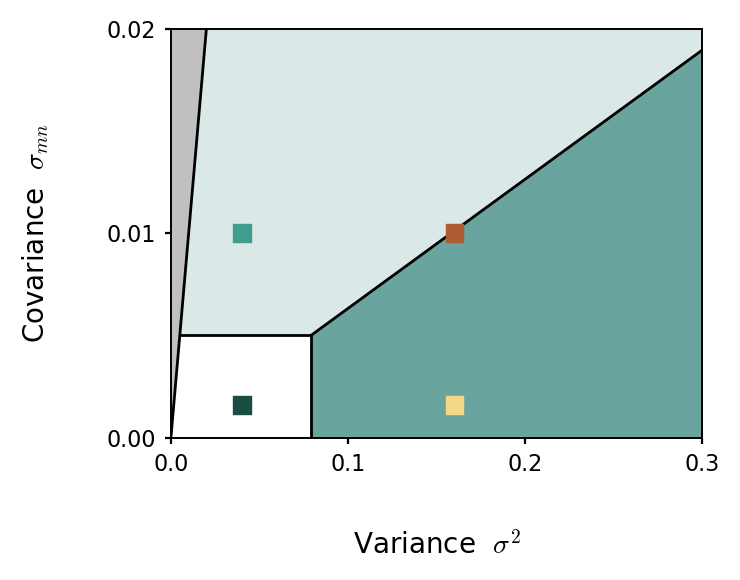

In [6]:
"""
Phase diagram
"""

bulk_color = 'teal'
outlier_color = 'cadetblue'
c_rescaled_dark = '#468F88'
location_colors = ['#194D44', '#409D90', '#F3D88A', '#AF5C34']

C = 200
N = 1000

xlim = 0.3
ylim = 0.02
step = 0.01

locations = np.array([[0.2, 0.04],   # decaying       [sigma, rho]
                      [0.2, 0.1],    # structured
                      [0.4, 0.04],   # chaotic
                      [0.4, 0.1]])   # intermediate regime

new_locations = locations.copy()
new_locations[:, 0] = locations[:, 0]**2  # convert sigma to sigma^2
new_locations[:, 1] = locations[:, 1]**2  # convert rho to sigma^{mn}


# define boundaries      

covariance_boundary = 1/C                                    # value of covariance for which outlier is equal to one
variance_boundary = np.sqrt(N)/(np.sqrt(C)*np.sqrt(N-C))     # value of variance for which bulk is equal to one
# variance_boundary = 1/np.sqrt(C)                           # simpler version
      
no_go_line = np.arange(0, xlim, step)  
variances = np.arange(variance_boundary, xlim+step, step)   
covariances = (np.sqrt(C) * variances * np.sqrt(N-C)) / (C * np.sqrt(N))   # value of covariance in terms of variance when outlier = bulk 
# covariances = (np.sqrt(C) * variances**2)/C                              # simpler version 


# plot graph 

fig, ax = plt.subplots(figsize=(3.8, 3), dpi=200)

ax.plot(variances, covariances, c='black', lw=1)                                                                #  line of bulk = outlier 
ax.plot([covariance_boundary, variance_boundary], [covariance_boundary, covariance_boundary], c='black', lw=1)  #  line of covariance = 1 
ax.plot([variance_boundary, variance_boundary], [0, covariance_boundary], c='black', lw=1)                      #  line of variance = 1 
ax.plot(no_go_line, no_go_line, c='black', lw=1)                                                                #  line of variance = covariance

ax.axvspan(0, np.max(variances), fc=c_rescaled_dark, alpha=0.2)
ax.fill_between(variances, covariances, fc='#157267', alpha=0.6)
ax.axvspan(0, variance_boundary, ymin=0, ymax=covariance_boundary/ylim, fc='white')
ax.fill_between(no_go_line, no_go_line, ylim, fc='silver', alpha=1, zorder=2)

ax.scatter(new_locations[:, 0], new_locations[:, 1], marker='s', s=40, c=location_colors, zorder=3)

ax.set_xlim([0, xlim])
ax.set_ylim([0, ylim])
ax.set_xlabel(r'Variance  $\sigma^2$', fontsize=10, labelpad=20)
ax.set_ylabel(r'Covariance  $\sigma_{mn}$', fontsize=10, labelpad=20)

plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)

fig.tight_layout()


### Samples of activity 

In [7]:
"""
Simulate network for different values of rho and sigma 
"""

data_outliers, data_bulks, theor_outliers, theor_bulks, matrices = [], [], [], [], []

ms = []

for coord in locations:
    
    sigma, rho = coord[0], coord[1]
    
    m, n = fct.make_connectivity_vectors(N, sigma, rho)  
    ms.append(m)
    P = np.outer(m, n)  
    P_tilde = fct.sparsify_columns(P, N, C)
    
    eigvals = sp.linalg.eigvals(P_tilde) 
    eigvals = eigvals[eigvals.argsort()[::-1]]  
    
    data_outliers.append((C/N) * np.dot(m, n))
    data_bulks.append(eigvals[1:])
    
    theor_outliers.append(C * rho**2)
    theor_bulks.append((np.sqrt(C) * sigma**2 * np.sqrt(N-C))/np.sqrt(N))
    matrices.append(P_tilde)


In [11]:
# Simulate activity 

T = 100
delta_t = 0.01

activations = simulate(matrices, T, delta_t, tau=1)

<ipython-input-12-a19a73dd6460>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '100'])


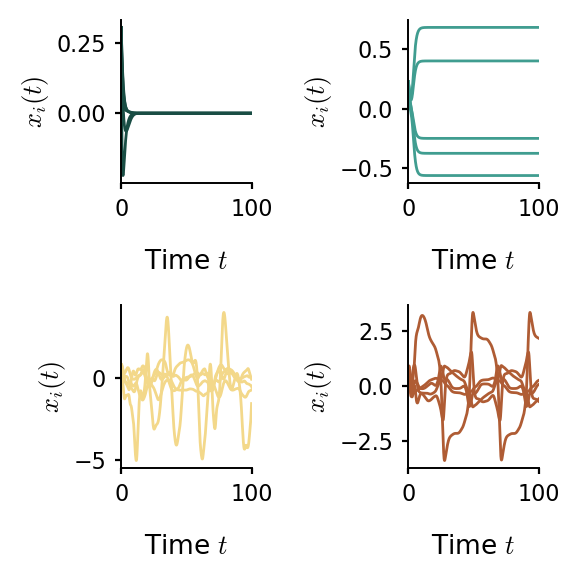

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(3, 3), dpi=200)
axes = axes.flatten()

for ind, ax in enumerate(axes):
    ax.set_xlabel('Time $t$', labelpad=10)
    ax.set_ylabel(r'$x_i(t)$',  labelpad=2)
    ax.set_xticklabels(['0', '100'])
    ax.set_xlim(0, int(T/delta_t))
    
    ax.locator_params(axis='x', nbins=1)
    ax.locator_params(axis='y', nbins=2)
    
for i in range(4):
    for j in range(5):
        axes[i].plot(activations[i][j], color=location_colors[i])
        
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout(pad=2)
plt.show()

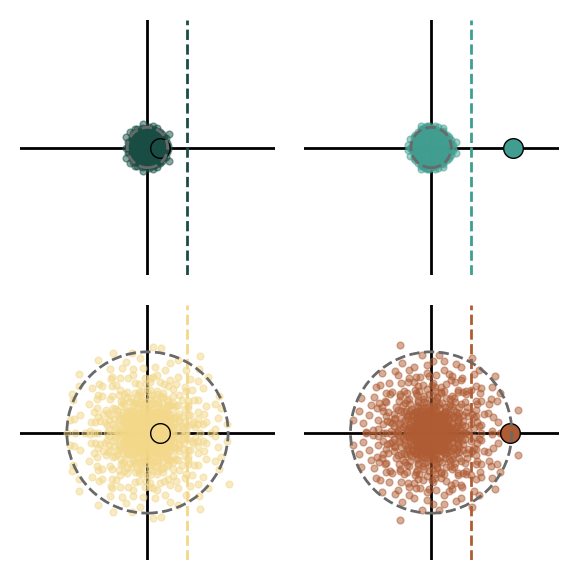

In [13]:
plot_eigenvalues(data_bulks, data_outliers, theor_bulks, theor_outliers, colors=location_colors,
                 rows=2, cols=2, figsize=(3, 3), dpi=200, lim=3.2, point_size=6, point_opacity=0.5)


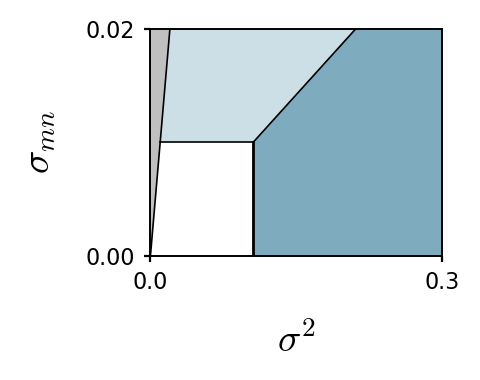

In [15]:
"""
Phase diagram - lower sparsity 
"""

N = 1000
C = 100

xlim = 0.3
ylim = 0.02
step = 0.01

inset_color = '#086184'

# define boundaries      
covariance_boundary = 1/C                                    # value of covariance for which outlier is equal to one
variance_boundary = np.sqrt(N)/(np.sqrt(C)*np.sqrt(N-C))     # value of variance for which bulk is equal to one
# variance_boundary = 1/np.sqrt(C)                           # simpler version
      
no_go_line = np.arange(0, xlim, step)  
variances = np.arange(variance_boundary, xlim+step, step)   
covariances = (np.sqrt(C) * variances * np.sqrt(N-C)) / (C * np.sqrt(N))   # value of covariance in terms of variance when outlier = bulk 
# covariances = (np.sqrt(C) * variances**2)/C                              # simpler version 

# plot graph 

fig, ax = plt.subplots(figsize=(2.5, 2), dpi=200)

ax.plot(variances, covariances, c='black', lw=0.6)                                                                #  line of bulk = outlier 
ax.plot([covariance_boundary, variance_boundary], [covariance_boundary, covariance_boundary], c='black', lw=0.6)  #  line of covariance = 1 
ax.plot([variance_boundary, variance_boundary], [0, covariance_boundary], c='black', lw=1)                        #  line of variance = 1 
ax.plot(no_go_line, no_go_line, c='black', lw=0.6)                                                                #  line of variance = covariance

ax.axvspan(0, np.max(variances), fc=inset_color, alpha=0.2)
ax.fill_between(variances, covariances, fc=inset_color, alpha=0.4)
ax.axvspan(0, variance_boundary, ymin=0, ymax=covariance_boundary/ylim, fc='white')
ax.fill_between(no_go_line, no_go_line, ylim, fc='silver', alpha=1, zorder=2)

ax.set_xlim([0, xlim])
ax.set_ylim([0, ylim])
ax.set_xlabel(r'$\sigma^2$', fontsize=14, labelpad=10)
ax.set_ylabel(r'$\sigma_{mn}$', fontsize=14, labelpad=10)

ax.set_xticks([0, 0.3])
ax.set_yticks([0, 0.02])

plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)

fig.tight_layout()


### Activity along $\mathbf{m}$ as function of sparsity

In [19]:
def simulate(matrix, T=100, delta_t=0.1, tau=1):

    timesteps = int(T / delta_t)

    N = matrix.shape[0]
    x = np.zeros((N, timesteps))  
    x[:, 0] = np.random.rand()
    for i in range(timesteps - 1):
        x[:, i + 1] = x[:, i] + delta_t * (- x[:, i] + np.dot(matrix, np.tanh(x[:, i]))) / tau
        
    return x

In [132]:
"""
Activity along m as function of C
"""

N = 1000
sigma = np.sqrt(0.2)
rho = np.sqrt(0.01)
T = 15
delta_t = 0.01

repeats = 20

Cs = np.linspace(50, 1000, 12).astype(int)

overlaps_activity_pos_avg = []
overlaps_activity_neg_avg = []

kappa_var_avg = []

for C in Cs:
    
    overlaps_activity = np.zeros(repeats)
    kappa_var = []
    
    for r in range(repeats):
        
        m, n = fct.make_connectivity_vectors(N, sigma, rho)
        P = np.outer(m, n)
        P_tilde = fct.sparsify_columns(P, N, C)

        activations = simulate(P_tilde, T, delta_t, tau=1)
        
        kappas = [np.tanh(activations[:, -1-i]).dot(m) / N for i in range(100)]

        overlaps_activity[r] = np.mean(kappas)
        kappa_var.append(np.var(kappas))

    overlaps_activity_pos_avg.append(np.mean(overlaps_activity[overlaps_activity >= 0]))
    overlaps_activity_neg_avg.append(np.mean(overlaps_activity[overlaps_activity < 0]))
    
    kappa_var_avg.append(np.mean(kappa_var))


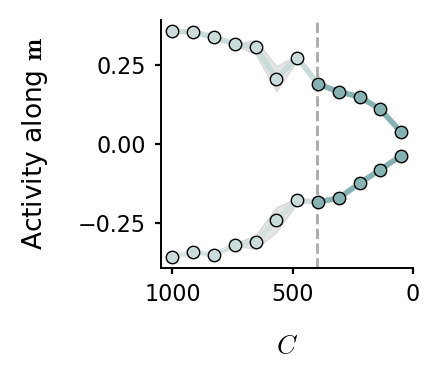

In [145]:
fig, ax = plt.subplots(figsize=(2.3, 2), dpi=200)

cut_ind = np.where(np.sqrt(Cs) * sigma**2 > Cs * rho**2)[0][-1] +1  # where bulks > outliers

ax.plot(Cs[:cut_ind], overlaps_activity_pos_avg[:cut_ind], color='#86B2B2', lw=2)
ax.plot(Cs[:cut_ind], overlaps_activity_neg_avg[:cut_ind], color='#86B2B2', lw=2)

ax.plot(Cs[cut_ind-1:], overlaps_activity_pos_avg[cut_ind-1:], color='#C9DCDB', lw=2)
ax.plot(Cs[cut_ind-1:], overlaps_activity_neg_avg[cut_ind-1:], color='#C9DCDB', alpha=0.6, lw=2)


ax.fill_between(Cs[cut_ind-1:], np.array(overlaps_activity_pos_avg[cut_ind-1:])-np.array(kappa_var_avg[cut_ind-1:]), np.array(overlaps_activity_pos_avg[cut_ind-1:])+np.array(kappa_var_avg[cut_ind-1:]), color='gray', alpha=0.2)
ax.fill_between(Cs[cut_ind-1:], np.array(overlaps_activity_neg_avg[cut_ind-1:])-np.array(kappa_var_avg[cut_ind-1:]), np.array(overlaps_activity_neg_avg[cut_ind-1:])+np.array(kappa_var_avg[cut_ind-1:]), color='gray', alpha=0.2)

ax.fill_between(Cs[:cut_ind], np.array(overlaps_activity_pos_avg[:cut_ind])-np.array(kappa_var_avg[:cut_ind]), np.array(overlaps_activity_pos_avg[:cut_ind])+np.array(kappa_var_avg[:cut_ind]), color='gray', alpha=0.2)
ax.fill_between(Cs[:cut_ind], np.array(overlaps_activity_neg_avg[:cut_ind])-np.array(kappa_var_avg[:cut_ind]), np.array(overlaps_activity_neg_avg[:cut_ind])+np.array(overlaps_activity_neg_std[:cut_ind]), color='gray', alpha=0.2)


ax.axvline(sigma**4 / rho**4, color='darkgray', ls='--')  # when bulk crosses outlier

ax.scatter(Cs[:cut_ind], overlaps_activity_neg_avg[:cut_ind], fc='#86B2B2', ec='black', lw=.5, label='Data', s=20, zorder=3, clip_on=False)
ax.scatter(Cs[:cut_ind], overlaps_activity_pos_avg[:cut_ind], fc='#86B2B2', ec='black', lw=.5, label='Data', s=20, zorder=3, clip_on=False)

ax.scatter(Cs[cut_ind:], overlaps_activity_neg_avg[cut_ind:], fc='#C9DCDB', ec='black', lw=.5, label='Data', s=20, zorder=3, clip_on=False)
ax.scatter(Cs[cut_ind:], overlaps_activity_pos_avg[cut_ind:], fc='#C9DCDB', ec='black', lw=.5, label='Data', s=20, zorder=3, clip_on=False)

ax.set_ylabel(r'Activity along $\mathbf{m}$')
ax.set_xlabel(r'$C$')
ax.invert_xaxis()
ax.set_xticks([1000, 500, 0])

plt.locator_params(axis='y', nbins=3)
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()

In [86]:
"""
Activity along m as function of N
"""

C = 500
sigma = np.sqrt(0.2)
rho = np.sqrt(0.01)

repeats = 10

Ns = np.linspace(C, 1000, 12).astype(int)

overlaps_activations_pos_avg = []
overlaps_activations_neg_avg = []

overlaps_activity_pos_avg = []
overlaps_activity_neg_avg = []

for N in Ns:
    
    overlaps_activations = np.zeros(repeats)
    overlaps_activity = np.zeros(repeats)
    
    for r in range(repeats):
        
        m, n = fct.make_connectivity_vectors(N, sigma, rho)
        P = np.outer(m, n)
        P_tilde = fct.sparsify_columns(P, N, C)

        activations = simulate(P_tilde, T, delta_t, tau=1)
        overlaps_activations[r] = np.mean([activations[:, -i].dot(m)/ (N * sigma**2) for i in range(100)])   # mean overlap of last 10 iterations 
        overlaps_activity[r] = np.mean([np.tanh(activations[:, -i]).dot(m)/ (N * sigma**2) for i in range(100)])

    overlaps_activations_pos_avg.append(np.mean(overlaps_activations[overlaps_activations >= 0]))
    overlaps_activations_neg_avg.append(np.mean(overlaps_activations[overlaps_activations < 0]))
    overlaps_activity_pos_avg.append(np.mean(overlaps_activity[overlaps_activity >= 0]))
    overlaps_activity_neg_avg.append(np.mean(overlaps_activity[overlaps_activity < 0]))

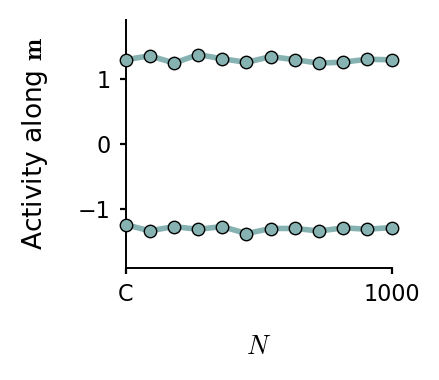

In [168]:
fig, ax = plt.subplots(figsize=(2.3, 2), dpi=200)

ax.plot(Ns, overlaps_activity_pos_avg, color='#86B2B2', lw=2)
ax.plot(Ns, overlaps_activity_neg_avg, color='#86B2B2', lw=2)

ax.scatter(Ns, overlaps_activity_neg_avg, fc='#86B2B2', ec='black', lw=.5, label='Data', s=20, zorder=3, clip_on=False)
ax.scatter(Ns, overlaps_activity_pos_avg, fc='#86B2B2', ec='black', lw=.5, label='Data', s=20, zorder=3, clip_on=False)

ax.set_ylabel(r'Activity along $\mathbf{m}$')
ax.set_xlabel(r'$N$')
ax.set_xticks([C, 1000])
ax.set_xticklabels(['C', 1000])

ax.set_ylim(-1.9, 1.9)
ax.set_xlim(C, 1000)

plt.locator_params(axis='y', nbins=3)
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()